In [56]:
from gs_quant.instrument import FXOption, FXForward
from gs_quant.backtests.triggers import (
    PeriodicTrigger,
    PeriodicTriggerRequirements,
    StrategyRiskTrigger,
    RiskTriggerRequirements,
    TriggerDirection,
)
from gs_quant.backtests.actions import AddTradeAction, HedgeAction
from gs_quant.backtests.backtest_objects import ScaledTransactionModel
from gs_quant.backtests.generic_engine import GenericEngine
from gs_quant.backtests.strategy import Strategy
from gs_quant.risk import FXDelta

import datetime as dt

In [2]:
from gs_quant.session import GsSession

GsSession.use()

Simplest backtest.  Buy a trade on a periodic basis.  Hold that trade for some number of days and exit the trade.

Here we buy an option every day between 4 Aug and 4 Sep and we hold each of those options for 1 week.  We convert this idea into a Strategy object.

In [3]:
opt = FXOption(pair='EURUSD', expiration_date='3m', strike_price='25d', option_type='Call', premium=0)

action = AddTradeAction(priceables=opt, trade_duration='1w')
trigger = PeriodicTrigger(
    trigger_requirements=PeriodicTriggerRequirements(
        start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1b'
    ),
    actions=action,
)

strategy = Strategy(initial_portfolio=None, triggers=trigger)

strategy objects can be run by Engines such as the GenericEngine

In [4]:
ge = GenericEngine()
backtest = ge.run_backtest(strategy=strategy, start=dt.date(2025, 8, 4), end=dt.date(2025, 9, 4), frequency='1b')

100%|█████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.09it/s]


when we run a backtest the engine will move through time from the start to the end and for each date determine if a trigger has triggered and if
it has it will apply the action(s) associated with the trigger.  We can see that the backtest result object hold a dictionary of every day in the
backtest and the portfolio holding on each date.

In [5]:
backtest.portfolio_dict

defaultdict(gs_quant.markets.portfolio.Portfolio,
            {datetime.date(2025, 8, 4): Portfolio(1 instrument(s)),
             datetime.date(2025, 8, 5): Portfolio(2 instrument(s)),
             datetime.date(2025, 8, 6): Portfolio(3 instrument(s)),
             datetime.date(2025, 8, 7): Portfolio(4 instrument(s)),
             datetime.date(2025, 8, 8): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 11): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 12): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 13): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 14): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 15): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 18): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 19): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 20): Portfolio(5 instrument(s)),
             datetime.date(2025, 8, 21): Portfolio(5 instr

you can see here that on the first day we have a single option then over the week we add an option but this tops out at 5 options as after this
point the we are exiting the positions.

the backtest object contains all the positions as above but also all the risks and pvs required for the backtest in the results.  It also has
some useful utilities like the result_summary and the trade_ledger

In [6]:
backtest.result_summary

,Price,Cumulative Cash,Transaction Costs,Total
2025-08-04,7.039538e+05,-7.039538e+05,0,0.000000e+00
2025-08-05,1.384686e+06,-1.401329e+06,0,-1.664271e+04
2025-08-06,2.438426e+06,-2.120211e+06,0,3.182143e+05
2025-08-07,3.064023e+06,-2.849922e+06,0,2.141012e+05
2025-08-08,3.987985e+06,-3.570582e+06,0,4.174028e+05
2025-08-11,2.955388e+06,-3.617959e+06,0,-6.625704e+05
2025-08-12,3.478294e+06,-3.509605e+06,0,-3.131080e+04
2025-08-13,3.906875e+06,-3.460997e+06,0,4.458788e+05
2025-08-14,3.141030e+06,-3.517508e+06,0,-3.764782e+05
2025-08-15,3.605119e+06,-3.542721e+06,0,6.239791e+04


Now we are going to take this basic example and extend it.  I want to extend the strategy I had above to also hedge the delta risk.  In order
to do this I am going to add a hedge action.  A hedge action required the risk you wish to hedge and the instrument you wish to hedge that
risk with.  When the hedge action is triggered the engine will calculate the risk and scale the hedge instrument such that the risk is hedged.

In [7]:
hedge_action = HedgeAction(
    risk=FXDelta(aggregation_level='Type'),
    priceables=FXForward(pair='EURUSD', settlement_date='2b'),
    trade_duration='1b',
)  # we are holding our hedge for one day.  So each day a new fwd is being added as a hedge.

# Note that we supplied an aggregation level to the risk to ensure the risk comes back as a scalar value.  Finer control of risks can be
# achieved by using a risk transformer and supplying this.
# Having created our hedge action we can now add it to the list of actions to be run when our trigger is triggered.

hedge_trigger = PeriodicTrigger(
    trigger_requirements=PeriodicTriggerRequirements(
        start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1b'
    ),
    actions=[action, hedge_action],
)  # now when the trigger triggers both actions will be done in order.

hedge_strategy = Strategy(initial_portfolio=None, triggers=hedge_trigger)

In [8]:
hedge_backtest = ge.run_backtest(
    strategy=hedge_strategy, start=dt.date(2025, 8, 4), end=dt.date(2025, 9, 4), frequency='1b'
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.42it/s]


if we check the result summary for this backtest we can check that the delta is 0 on all dates.

In [9]:
hedge_backtest.result_summary

,Price,FXDelta(aggregation_level:Type),Cumulative Cash,Transaction Costs,Total
2025-08-04,7.039538e+05,0.000000e+00,-7.039538e+05,0,0.000000
2025-08-05,1.384686e+06,0.000000e+00,-1.408141e+06,0,-23454.304906
2025-08-06,2.438426e+06,0.000000e+00,-2.382851e+06,0,55574.368854
2025-08-07,3.064023e+06,0.000000e+00,-3.024605e+06,0,39417.710660
2025-08-08,3.987985e+06,-1.490116e-08,-4.028740e+06,0,-40754.340909
2025-08-11,2.955388e+06,0.000000e+00,-3.261150e+06,0,-305761.320428
2025-08-12,3.478294e+06,-1.490116e-08,-3.831561e+06,0,-353266.819324
2025-08-13,3.906875e+06,0.000000e+00,-4.270443e+06,0,-363567.721780
2025-08-14,3.141030e+06,0.000000e+00,-3.617677e+06,0,-476646.930316
2025-08-15,3.605119e+06,1.490116e-08,-4.124625e+06,0,-519505.288948


now we are going to change this so that instead of buying an option every day we are going to buy every week but still hedge every day.  In
order to do this we are going to have two different triggers, one daily and one weekly with different actions.

In [10]:
weekly_trigger = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1w'),
    actions=action,
)
daily_trigger = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1b'),
    actions=hedge_action,
)

hedge_weekly_option_strategy = Strategy(initial_portfolio=None, triggers=[weekly_trigger, daily_trigger])

In [11]:
hedge_weekly_option_backtest = ge.run_backtest(
    strategy=hedge_weekly_option_strategy, start=dt.date(2025, 8, 4), end=dt.date(2025, 9, 4), frequency='1b'
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.41it/s]


if we look at the trade ledger for this backtest we can see that options are bought weekly but hedges are still done daily

In [13]:
hedge_weekly_option_backtest.trade_ledger()

,Open,Close,Open Value,Close Value,Long Short,Status,Trade PnL
Action1_Priceable0_2025-08-04,2025-08-04,2025-08-11,-703953.846673,637865.502946,-1,closed,-66088.343728
Action1_Priceable0_2025-08-11,2025-08-11,2025-08-18,-685241.75833,685891.313071,-1,closed,649.554742
Action1_Priceable0_2025-08-18,2025-08-18,2025-08-25,-641537.745143,747562.463969,-1,closed,106024.718826
Action1_Priceable0_2025-08-25,2025-08-25,2025-09-01,-664120.360966,608390.108042,-1,closed,-55730.252924
Action1_Priceable0_2025-09-01,2025-09-01,None,-671974.304719,0,-1,open,None
Action2_Priceable0_2025-08-04,2025-08-04,2025-08-05,0.000042,-6811.598662,-1,closed,-6811.59862
Action2_Priceable0_2025-08-05,2025-08-05,2025-08-06,-0.000076,-127463.975776,-1,closed,-127463.975852
Action2_Priceable0_2025-08-06,2025-08-06,2025-08-07,-0.000068,30876.67724,-1,closed,30876.677172
Action2_Priceable0_2025-08-07,2025-08-07,2025-08-08,0.000019,-76216.870412,-1,closed,-76216.870393
Action2_Priceable0_2025-08-08,2025-08-08,2025-08-11,0.000098,180086.64404,-1,closed,180086.644138


it would be useful if the name of the trades was more human readable.
We can control this by naming the trade and the actions.  Then the name of the instrument would be the action name_trade name_date the trade was
entered.

In [16]:
opt = FXOption(pair='EURUSD', expiration_date='3m', strike_price='25d', premium=0, name='EURUSD call')
add_action = AddTradeAction(priceables=opt, trade_duration='1w', name='add action')
fwd = FXForward(pair='EURUSD', settlement_date='2b', name='spot hedge')
named_hedge_action = HedgeAction(
    risk=FXDelta(aggregation_level='Type'), priceables=fwd, trade_duration='1b', name='hedge action'
)

weekly_trigger = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1w'),
    actions=add_action,
)
daily_trigger = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1b'),
    actions=named_hedge_action,
)

hedge_weekly_option_strategy = Strategy(initial_portfolio=None, triggers=[weekly_trigger, daily_trigger])
hedge_weekly_option_backtest = ge.run_backtest(
    strategy=hedge_weekly_option_strategy, start=dt.date(2025, 8, 4), end=dt.date(2025, 9, 4), frequency='1b'
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:08<00:00,  3.21it/s]


In [17]:
hedge_weekly_option_backtest.trade_ledger()

,Open,Close,Open Value,Close Value,Long Short,Status,Trade PnL
add action_EURUSD call_2025-08-04,2025-08-04,2025-08-11,-703953.846673,637865.502946,-1,closed,-66088.343728
add action_EURUSD call_2025-08-11,2025-08-11,2025-08-18,-685241.75833,685891.313071,-1,closed,649.554742
add action_EURUSD call_2025-08-18,2025-08-18,2025-08-25,-641537.745143,747562.463969,-1,closed,106024.718826
add action_EURUSD call_2025-08-25,2025-08-25,2025-09-01,-664120.360966,608390.108042,-1,closed,-55730.252924
add action_EURUSD call_2025-09-01,2025-09-01,None,-671974.304719,0,-1,open,None
hedge action_spot hedge_2025-08-04,2025-08-04,2025-08-05,0.000042,-6811.598662,-1,closed,-6811.59862
hedge action_spot hedge_2025-08-05,2025-08-05,2025-08-06,-0.000076,-127463.975776,-1,closed,-127463.975852
hedge action_spot hedge_2025-08-06,2025-08-06,2025-08-07,-0.000068,30876.67724,-1,closed,30876.677172
hedge action_spot hedge_2025-08-07,2025-08-07,2025-08-08,0.000019,-76216.870412,-1,closed,-76216.870393
hedge action_spot hedge_2025-08-08,2025-08-08,2025-08-11,0.000098,180086.64404,-1,closed,180086.644138


that's great but in reality we are trading all these instrument at mid which isn't very likely.  We should add some transaction costs
into the backtest to get something which mirrors reality better

In [27]:
t_cost = ScaledTransactionModel(
    'notional_amount', 0.00005
)  # We are going to add a 0.5bp transaction cost.  We could have charge scaled by risk as well
add_action_tcost = AddTradeAction(priceables=opt, trade_duration='1w', name='add action', transaction_cost=t_cost)
named_hedge_action_tcost = HedgeAction(
    risk=FXDelta(aggregation_level='Type'),
    priceables=fwd,
    trade_duration='1b',
    name='hedge action',
    transaction_cost=t_cost,
)

weekly_trigger_tcost = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1w'),
    actions=add_action_tcost,
)
daily_trigger_tcost = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1b'),
    actions=named_hedge_action_tcost,
)

hedge_weekly_option_strategy_tcost = Strategy(
    initial_portfolio=None, triggers=[weekly_trigger_tcost, daily_trigger_tcost]
)
hedge_weekly_option_backtest_tcost = ge.run_backtest(
    strategy=hedge_weekly_option_strategy_tcost, start=dt.date(2025, 8, 4), end=dt.date(2025, 9, 4), frequency='1b'
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:13<00:00,  1.95it/s]


In [28]:
hedge_weekly_option_backtest_tcost.result_summary

,Price,FXDelta(aggregation_level:Type),Cumulative Cash,Transaction Costs,Total
2025-08-04,703953.846631,0.000000e+00,-7.039538e+05,-6051.326333,-6051.326333
2025-08-05,687311.140464,0.000000e+00,-7.107654e+05,-8152.522301,-31606.827207
2025-08-06,854096.726246,-3.725290e-09,-8.382294e+05,-10459.843280,5407.461751
2025-08-07,816927.558111,0.000000e+00,-8.073527e+05,-12918.673655,-3343.859500
2025-08-08,872578.098512,3.725290e-09,-8.835696e+05,-15413.046675,-26404.562434
2025-08-11,685241.758261,0.000000e+00,-7.508592e+05,-27756.869337,-93374.336621
2025-08-12,828486.344621,3.725290e-09,-9.045100e+05,-30066.308412,-106089.987243
2025-08-13,941680.896567,0.000000e+00,-1.018543e+06,-32748.850904,-109611.008628
2025-08-14,749260.469448,0.000000e+00,-8.496859e+05,-35363.040760,-135788.422853
2025-08-15,856628.384519,0.000000e+00,-9.642024e+05,-37917.845073,-145491.909092


lets plot the pnl of the strategy with and without the transaction costs.

<Axes: >

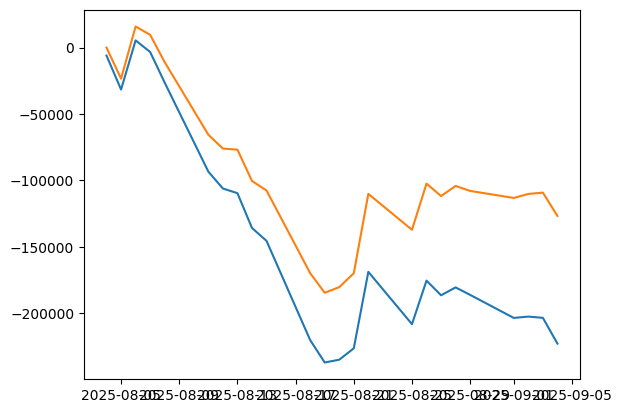

In [30]:
hedge_weekly_option_backtest_tcost.result_summary['Total'].plot()
hedge_weekly_option_backtest.result_summary['Total'].plot()

we can see that even a relatively low transaction cost of 0.5bp is having a significant effect.  Perhaps we are hedging too frequently.
We should go back to basics and look at exactly how much delta the options are producing.
We construct a backtest which just buys the calls and hedges on inception and when running the backtest we add the FXDelta risk to the risks to be calculated so
we can look at how much delta we are running

In [51]:
weekly_hedge_action = HedgeAction(
    risk=FXDelta(aggregation_level='Type'),
    priceables=FXForward(pair='EURUSD', settlement_date='1w'),
    trade_duration='1w',
    transaction_cost=t_cost,
    name='initial hedge',
)
# Note we are now hedging with a 1w fwd and holding for a week to tie in to the option schedule
weekly_option_and_hedge_trigger = PeriodicTrigger(
    PeriodicTriggerRequirements(start_date=dt.date(2025, 8, 4), end_date=dt.date(2025, 9, 4), frequency='1w'),
    actions=[add_action_tcost, initial_hedge_action],
)
weekly_option_strategy = Strategy(initial_portfolio=None, triggers=weekly_option_and_hedge_trigger)
weekly_option_backtest = ge.run_backtest(
    strategy=weekly_option_strategy,
    start=dt.date(2025, 8, 4),
    end=dt.date(2025, 9, 4),
    frequency='1b',
    risks=[FXDelta(aggregation_level='Type')],
)

100%|███████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.68it/s]


In [52]:
weekly_option_backtest.result_summary

,Price,FXDelta(aggregation_level:Type),Cumulative Cash,Transaction Costs,Total
2025-08-04,703953.846659,0.000000e+00,-703953.846659,-6051.957748,-6051.957748
2025-08-05,680489.942334,-3.667943e+04,-703953.846659,-6051.957748,-29515.862072
2025-08-06,719584.630378,4.109436e+06,-703953.846659,-6051.957748,9578.825971
2025-08-07,708224.341558,2.986270e+06,-703953.846659,-6051.957748,-1781.462848
2025-08-08,697124.384618,4.814721e+06,-703953.846659,-6051.957748,-12881.419788
2025-08-11,685241.758273,0.000000e+00,-780309.659995,-18155.376168,-113223.277890
2025-08-12,674788.154801,4.145061e+06,-780309.659995,-18155.376168,-123676.881362
2025-08-13,692719.834444,7.446583e+06,-780309.659995,-18155.376168,-105745.201719
2025-08-14,624955.188757,2.773939e+06,-780309.659995,-18155.376168,-173509.847406
2025-08-15,631145.420649,6.254668e+06,-780309.659995,-18155.376168,-167319.615514


maybe we can try a strategy which only hedges if the abs(delta) is greater than 4e6.
To do this instead of hedging on a periodic basis we need a different type of trigger which triggers dependent on the risk on the strategy.
This is the StrategyRiskTrigger

In [53]:
risk_hedge_trigger_up = StrategyRiskTrigger(
    RiskTriggerRequirements(
        risk=FXDelta(aggregation_level='Type'), trigger_level=4e6, direction=TriggerDirection.ABOVE
    ),
    actions=named_hedge_action_tcost,
)
risk_hedge_trigger_down = StrategyRiskTrigger(
    RiskTriggerRequirements(
        risk=FXDelta(aggregation_level='Type'), trigger_level=-4e6, direction=TriggerDirection.BELOW
    ),
    actions=named_hedge_action_tcost,
)
risk_hedge_strategy = Strategy(
    initial_portfolio=None, triggers=[weekly_option_and_hedge_trigger, risk_hedge_trigger_up, risk_hedge_trigger_down]
)
risk_hedge_backtest = ge.run_backtest(
    strategy=risk_hedge_strategy, start=dt.date(2025, 8, 4), end=dt.date(2025, 9, 4), frequency='1b'
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


In [54]:
risk_hedge_backtest.trade_ledger()

,Open,Close,Open Value,Close Value,Long Short,Status,Trade PnL
Action6_Priceable0_2025-08-04,2025-08-04,2025-08-11,0.000015,-28979.558009,-1,closed,-28979.557994
Action6_Priceable0_2025-08-11,2025-08-11,2025-08-18,0.000056,-141949.783377,-1,closed,-141949.78332
Action6_Priceable0_2025-08-18,2025-08-18,2025-08-25,0.00003,-113072.7977,-1,closed,-113072.79767
Action6_Priceable0_2025-08-25,2025-08-25,2025-09-01,-0.000106,50433.378489,-1,closed,50433.378383
Action6_Priceable0_2025-09-01,2025-09-01,None,-0.000032,0,-1,open,None
add action_EURUSD call_2025-08-04,2025-08-04,2025-08-11,-703953.846673,637865.502946,-1,closed,-66088.343728
add action_EURUSD call_2025-08-11,2025-08-11,2025-08-18,-685241.75833,685891.313071,-1,closed,649.554742
add action_EURUSD call_2025-08-18,2025-08-18,2025-08-25,-641537.745143,747562.463969,-1,closed,106024.718826
add action_EURUSD call_2025-08-25,2025-08-25,2025-09-01,-664120.360966,608390.108042,-1,closed,-55730.252924
add action_EURUSD call_2025-09-01,2025-09-01,None,-671974.304719,0,-1,open,None


so now we can see that we hedging on a sparse schedule and if we look at the result summary we can see that the delta is not always zero but that
the cumulative transaction costs are lower.

In [55]:
risk_hedge_backtest.result_summary

,Price,FXDelta(aggregation_level:Type),Cumulative Cash,Transaction Costs,Total
2025-08-04,703953.846659,0.000000e+00,-703953.846659,-6051.957748,-6051.957748
2025-08-05,680489.942334,-3.667943e+04,-703953.846659,-6051.957748,-29515.862072
2025-08-06,719584.630389,0.000000e+00,-703953.846670,-6257.577693,9373.206026
2025-08-07,708224.341558,2.986270e+06,-698904.855552,-6463.197637,2856.288369
2025-08-08,697124.384600,0.000000e+00,-698904.855533,-6704.107429,-8484.578362
2025-08-11,685241.758273,0.000000e+00,-741707.043607,-19048.435640,-75513.720973
2025-08-12,674788.154810,0.000000e+00,-741707.043616,-19255.838305,-86174.727110
2025-08-13,692719.834422,9.313226e-10,-760498.207553,-19835.838794,-87614.211925
2025-08-14,624955.188757,2.773939e+06,-716313.637955,-20208.436618,-111566.885817
2025-08-15,631145.420621,9.313226e-10,-716313.637928,-20521.395873,-105689.613179
